Datasets used: 
- `Subject List Dataset(SSL)` :<br>
The information displayed represents a de-identified listing of arrest data from August 1, 2012 to July 31, 2016, that was used by the Chicago Police Department’s Strategic Subject Algorithm,<br> created by the Illinois Institute of Technology and funded through a Department of Justice Bureau of Justice Assistance grant,<br> to create a risk assessment score known as the Strategic Subject List or “SSL.” <br>These scores reflect an individual’s probability of being involved in a shooting incident either as a victim or an offender.<br> Scores are calculated and placed on a scale ranging from 0 (extremely low risk) to 500 (extremely high risk).

Reference Links: https://data.cityofchicago.org/Public-Safety/Strategic-Subject-List-Historical/4aki-r3np

In [1]:
import pandas as pd
import numpy as np

import os
import sys
module_path = os.path.abspath(os.path.join('..', '..'))
if module_path not in sys.path:
    sys.path.append(module_path)\

import warnings
warnings.filterwarnings('ignore')
import facts
from facts.clean import clean_dataset
from facts import valid_ifthens_with_coverage_correctness, rules2rulesbyif
from facts.models import customLogisticRegression
from facts.parameters import ParameterProxy
from facts.formatting import recourse_report_reverse, print_recourse_report, print_recourse_report_cumulative, print_recourse_report_KStest_cumulative
from facts.utils import load_rules_by_if
from aif360.sklearn.datasets import fetch_compas
from facts.fairness_metrics_aggr import get_diff_table, get_comb_df, get_analysis_dfs, get_diff_real_diff_drop,get_other_ranks_divided,get_map_metric_to_max_rank


In [3]:
from pathlib import Path

computed_rules_file = Path("..") / "results-cache" / "SSL" / "rulesSSL_atomic.data"
computed_rules_with_cumulative_file = Path("..") / "results-cache" / "SSL" / "rulesSSL_cumulative.data"

In [4]:
cost_budget = 10
top_count = 20
c_inf = 5

In [5]:
urlfile= "https://raw.githubusercontent.com/samuel-yeom/fliptest/master/exact-ot/chicago-ssl-clean.csv"

X = pd.read_csv(urlfile)
sensitive_attribute = "SEX CODE CD"
df = clean_dataset(X,'SSL')
df.head()

,SSL SCORE,PREDICTOR RAT AGE AT LATEST ARREST,PREDICTOR RAT VICTIM SHOOTING INCIDENTS,PREDICTOR RAT VICTIM BATTERY OR ASSAULT,PREDICTOR RAT ARRESTS VIOLENT OFFENSES,PREDICTOR RAT GANG AFFILIATION,PREDICTOR RAT NARCOTIC ARRESTS,PREDICTOR RAT TREND IN CRIMINAL ACTIVITY,PREDICTOR RAT UUW ARRESTS,SEX CODE CD,RACE CODE CD
0,0,20-30,0,1,4,1,1,"(0.3, 7.3]",1,M,BLK
1,0,20-30,0,9,1,1,0,"(0.3, 7.3]",0,M,WHI
2,0,10-20,1,2,1,1,3,"(0.3, 7.3]",0,M,WHI
3,0,10-20,1,1,4,1,0,"(0.3, 7.3]",1,M,BLK
4,0,10-20,0,0,5,0,0,"(0.3, 7.3]",3,M,BLK


In [6]:
y = df['SSL SCORE']
X = df.drop('SSL SCORE', axis=1)

num_features = X._get_numeric_data().columns.to_list()
cate_features = X.select_dtypes(include=['object','category']).columns.to_list()
ord_features=[]

In [7]:
rules_with_atomic_correctness = load_rules_by_if(computed_rules_file)
rules_with_cumulative_correctness = load_rules_by_if(computed_rules_with_cumulative_file)

In [8]:
feature_weights = {'PREDICTOR RAT AGE AT LATEST ARREST':10,	'PREDICTOR RAT VICTIM SHOOTING INCIDENTS':1,	
'PREDICTOR RAT VICTIM BATTERY OR ASSAULT':1,	'PREDICTOR RAT ARRESTS VIOLENT OFFENSES':1,	'PREDICTOR RAT GANG AFFILIATION':1,
'PREDICTOR RAT NARCOTIC ARRESTS':1,	'PREDICTOR RAT TREND IN CRIMINAL ACTIVITY':1,	'PREDICTOR RAT UUW ARRESTS':1,	'SEX CODE CD':100,	'RACE CODE CD':100}

features_with_binary_cost = cate_features
features_with_proportional_cost = num_features
ord_features=[]

comparators = facts.feature_change_builder(
    X,
    num_cols=features_with_proportional_cost,
    cate_cols=features_with_binary_cost,
    ord_cols=ord_features,
    feature_weights=feature_weights,
    num_normalization=False,
    #feats_to_normalize = ["capital-gain","capital-loss"]
)
params = ParameterProxy(featureChanges=comparators)

# Macro Viepoint

## Equal Cost of Effectiveness (Macro)

In [9]:
top_rules, subgroup_costs = facts.select_rules_subset(
    rules_with_atomic_correctness,
    metric="min-above-thr",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=50,
    cor_threshold=0.7,
    filter_sequence = [
        "remove-contained",
        "remove-below-thr",        
        # "remove-fair-rules",
        "keep-only-min-change"
    ],
    params=params
)

print_recourse_report(
    top_rules,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    metric_name = 'Equal Cost of Effectiveness (Macro) (threshold = 0.7)'
)

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 1, PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT UUW ARRESTS = 0:
	Protected Subgroup 'BLK', 12.56% covered
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30, PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0 with effectiveness 97.10%.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 30-40, PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0 with effectiveness 99.90%.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 40-50, PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0 with effectiveness 100.00%.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 50-60, PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0 with effectiveness 100.00%.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 60-70, PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0 with effectiveness 100.00%.
		Aggregate cost of the above recourses = 11.00
	Protected Subgroup 'WHI', 9.67% covered
		Make PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0 with effectivenes

## Equal Choice for Recourse

In [10]:
top_rules, subgroup_costs = facts.select_rules_subset(
    rules_with_atomic_correctness,
    metric="num-above-thr",
    sort_strategy="generic-sorting-ignore-forall-subgroups-empty",
    top_count=50,
    cor_threshold=0.7,
    filter_sequence = [
        "remove-contained",
        "remove-below-thr",
        "remove-fair-rules"
    ],
    params=params
)

print_recourse_report(
    top_rules,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    metric_name= 'Equal Choice for Recourse (threshold = 0.7)'
)

If PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3], SEX CODE CD = M:
	Protected Subgroup 'BLK', 7.04% covered
		No recourses for this subgroup!
		Aggregate cost of the above recourses = 0.00
	Protected Subgroup 'WHI', 12.31% covered
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 91.11%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 82.96%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 82.96%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 82.96%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3], SEX CODE CD = F with effectiveness 91.11%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1], SEX CODE CD = F with effectiveness 82.96%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1], SEX CODE CD = F with effect

# Micro Viewpoint

## Equal Conditional Mean Recourse

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0:
	Protected Subgroup 'BLK', 1.67% covered
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30 with effectiveness 99.32% and counterfactual cost = 10.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 30-40 with effectiveness 100.00% and counterfactual cost = 10.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 40-50 with effectiveness 100.00% and counterfactual cost = 10.0.
		Make PREDIC

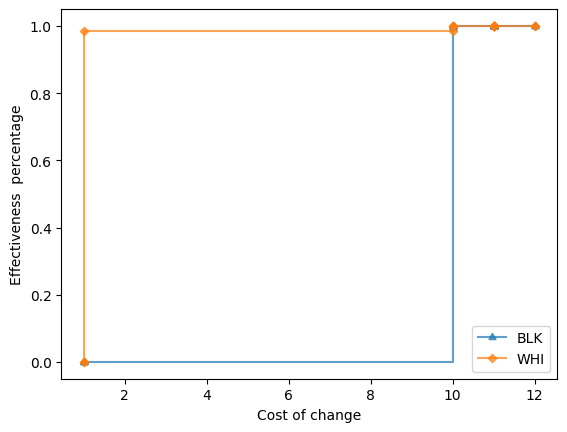

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0:
	Protected Subgroup 'BLK', 2.46% covered
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30 with effectiveness 98.93% and counterfactual cost = 10.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 30-40 with effectiveness 100.00% and counterfactual cost = 10.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 40-50 with effectiveness 100.00% and counterfactual cost = 10.0.
		Make PREDIC

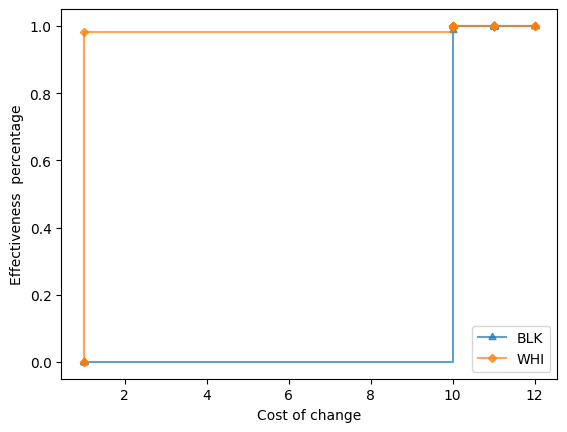

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0, SEX CODE CD = M:
	Protected Subgroup 'BLK', 1.13% covered
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30 with effectiveness 100.00% and counterfactual cost = 10.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 30-40 with effectiveness 100.00% and counterfactual cost = 10.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 40-50 with effectiveness 100.00% and counterfactual cost = 10.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 50-60 with effectiveness 100.00% and counterfactual cost = 10.0.
		M

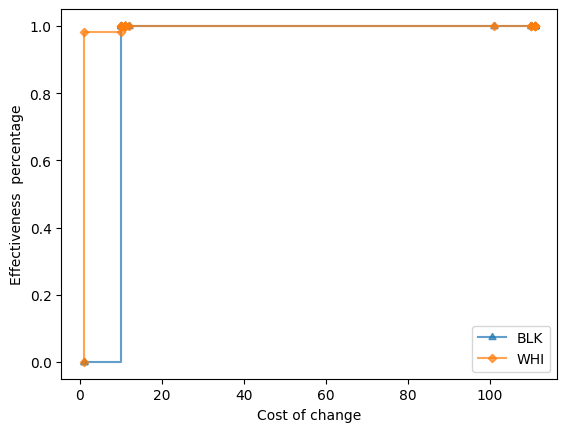

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0, SEX CODE CD = M:
	Protected Subgroup 'BLK', 1.73% covered
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30 with effectiveness 98.46% and counterfactual cost = 10.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 30-40 with effectiveness 100.00% and counterfactual cost = 10.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 40-50 with effectiveness 100.00% and counterfactual cost = 10.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 50-60 with effectiveness 100.00% and counterfactual cost = 10.0.
		Ma

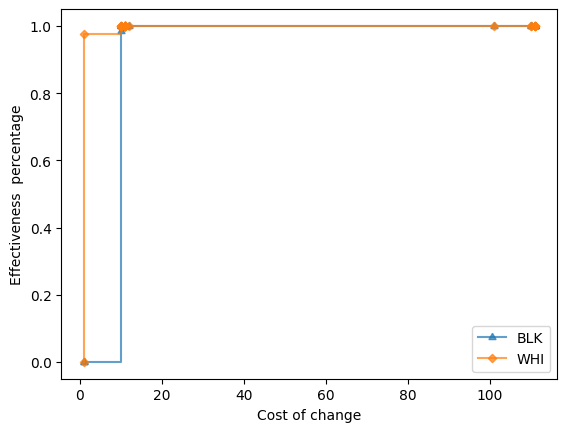

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT GANG AFFILIATION = 1, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0, PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0, SEX CODE CD = M:
	Protected Subgroup 'BLK', 1.96% covered
		Make PREDICTOR RAT GANG AFFILIATION = 0 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 0.00% and counterfactual cost = 2.0.
		Make PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 0.00% and counterfactual cost = 2.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30, PREDICTOR RAT GANG AFFILIATION = 0 with effectiveness 84.76% and counterfactual cost = 11.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 30-40, PREDICTOR RAT GANG AFFILIATIO

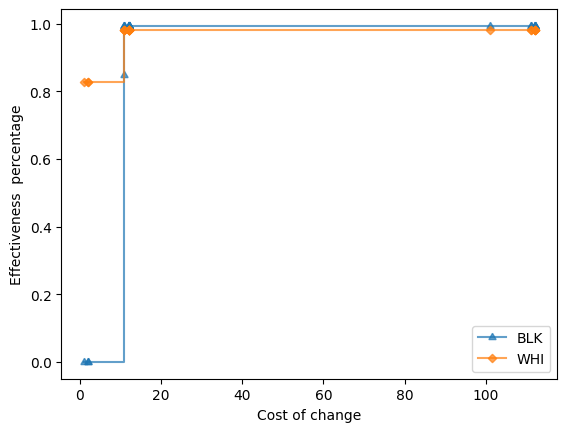

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT GANG AFFILIATION = 1, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0, PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0:
	Protected Subgroup 'BLK', 2.06% covered
		Make PREDICTOR RAT GANG AFFILIATION = 0 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 0.00% and counterfactual cost = 2.0.
		Make PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 0.00% and counterfactual cost = 2.0.
		Make PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 2.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30, PREDICTOR RAT GANG AFFILIATION = 0 wi

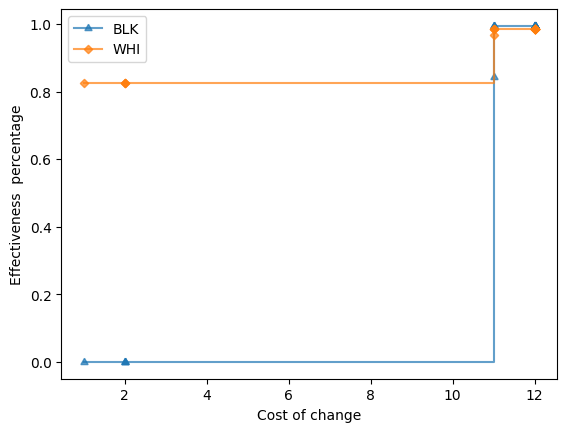

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0:
	Protected Subgroup 'BLK', 1.92% covered
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 4.82% and counterfactual cost = 1.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30 with effectiveness 98.80% and counterfactual cost = 10.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 30-40 with effectiveness 100.00% and counterfactual cost = 10.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 40-50 with effectiveness 100.00% and counterfactual cost = 10.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 50-60

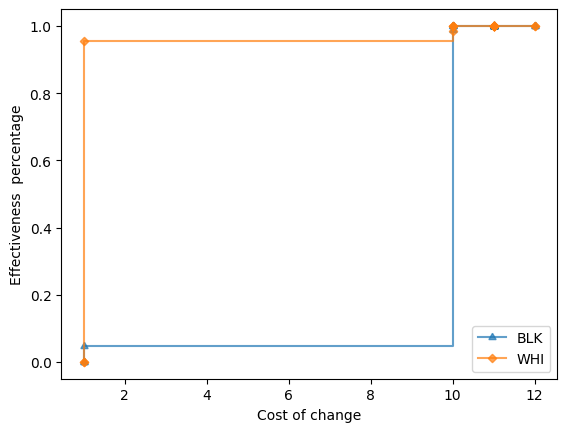

In [11]:
top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
    rules_with_cumulative_correctness,
    metric="fairness-of-mean-recourse-conditional",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=top_count,
    filter_sequence = [
        "remove-contained",
        "remove-fair-rules"
    ],
    params=params
)

print_recourse_report_cumulative(
    top_rules,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    show_cumulative_plots=True,
    correctness_metric=False
)

## Equal Cost of Effectiveness (Micro)

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 1, PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT UUW ARRESTS = 0:
	Protected Subgroup 'BLK', 12.56% covered
		Make PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0 with effectiveness 63.05% and counterfactual cost = 1.0.
		Make PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0, PREDICTOR RAT NARCOTIC ARRESTS = 1 with effectiveness 63.05% and counterfactual cost = 2.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30, PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0 with effectiveness 97.44% and counterfactual cost = 11.0.
		Aggregate cost of the above recourses = 11.00
	Protected Subgroup 'WHI', 9.67% covered
		Make PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0 with effectiveness 81.55% and counterfactual cost = 1.0.
		Aggregate cost of the above recourses = 1.00
	Bias against BLK due to Equal Effectiveness. Unfairness score = 10.0.
	Cumulative effectiveness plot for the above rec

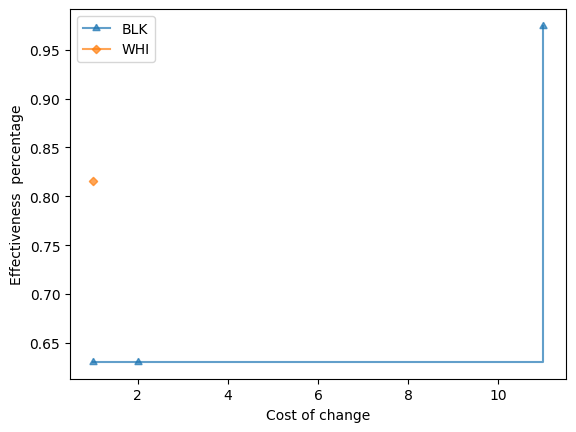

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 1, PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT UUW ARRESTS = 0, SEX CODE CD = M:
	Protected Subgroup 'BLK', 10.78% covered
		Make PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0 with effectiveness 59.42% and counterfactual cost = 1.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30, PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0 with effectiveness 96.37% and counterfactual cost = 11.0.
		Aggregate cost of the above recourses = 11.00
	Protected Subgroup 'WHI', 9.90% covered
		Make PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0 with effectiveness 77.19% and counterfactual cost = 1.0.
		Aggregate cost of the above recourses = 1.00
	Bias against BLK due to Equal Effectiveness. Unfairness score = 10.0.
	Cumulative effectiveness plot for the above recourses:


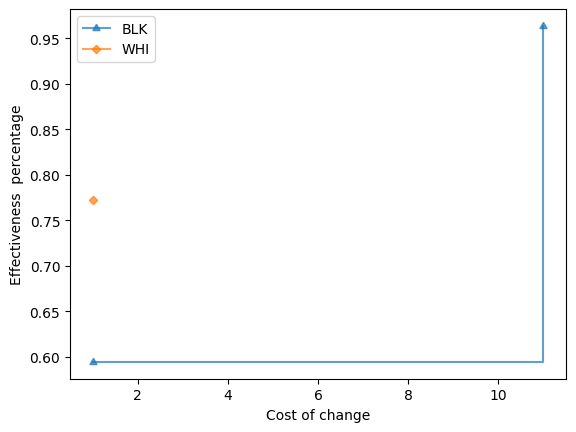

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 1, PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT UUW ARRESTS = 0, SEX CODE CD = M:
	Protected Subgroup 'BLK', 9.04% covered
		Make PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0 with effectiveness 62.43% and counterfactual cost = 1.0.
		Make PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0, PREDICTOR RAT NARCOTIC ARRESTS = 1 with effectiveness 62.43% and counterfactual cost = 2.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30, PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0 with effectiveness 97.49% and counterfactual cost = 11.0.
		Aggregate cost of the above recourses = 11.00
	Protected Subgroup 'WHI', 7.39% covered
		Make PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0 with effectiveness 83.33% and counterfactual cost = 1.0.
		Aggregate cost of the above recourses = 1.00
	Bias against BLK due to Equal Effectiveness. Unfairness score = 10.0.
	Cumulative effectiveness plot f

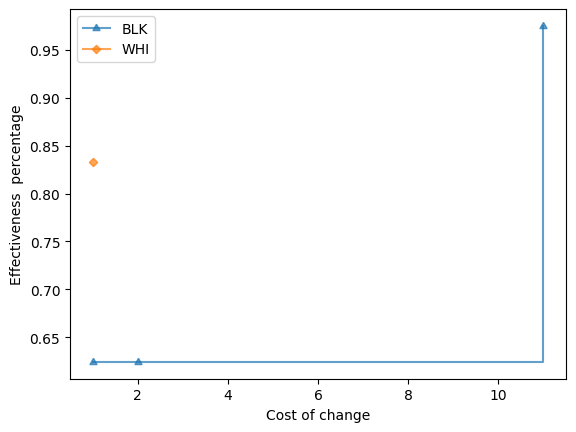

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3], SEX CODE CD = M:
	Protected Subgroup 'BLK', 8.50% covered
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 48.44% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 48.44% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 48.44% and counterfactual cost = 1.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30 with effectiveness 68.70% and counterfactual cost = 10.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 73.09% and counterfactual cost = 11.0.
		Aggregate cost of the above recourses = 11.00
	Protected Subgroup 'WHI', 16.05% covered
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with eff

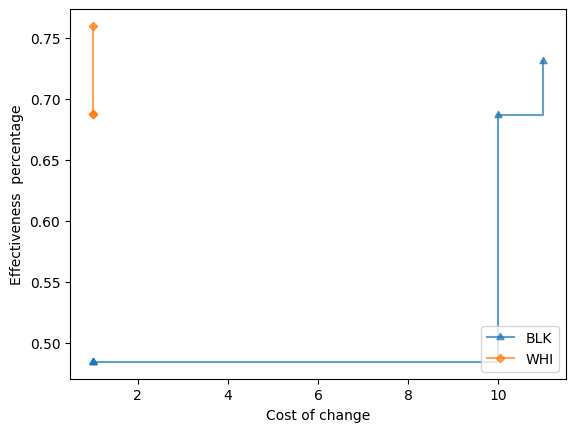

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 1:
	Protected Subgroup 'BLK', 5.02% covered
		Make PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0 with effectiveness 40.83% and counterfactual cost = 1.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0 with effectiveness 90.56% and counterfactual cost = 11.0.
		Aggregate cost of the above recourses = 11.00
	Protected Subgroup 'WHI', 4.61% covered
		Make PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0 with effectiveness 70.00% and counterfactual cost = 1.0.
		Aggregate cost of the above recourses = 1.00
	Bias against BLK due to Equal Effectiveness. Unfairness score = 10.0.
	Cumulative effectiveness plot for the above recourses:


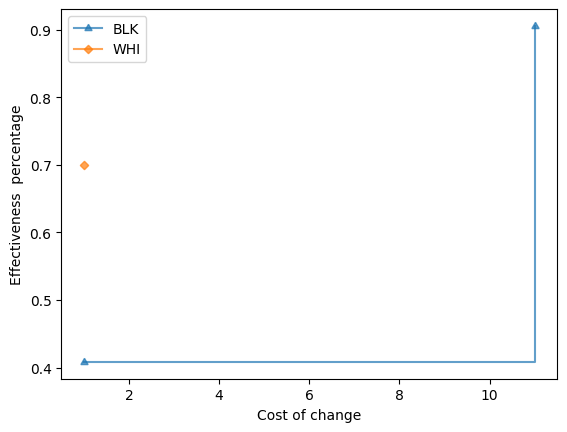

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 1:
	Protected Subgroup 'BLK', 3.99% covered
		Make PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0 with effectiveness 44.33% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0 with effectiveness 44.33% and counterfactual cost = 2.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0 with effectiveness 91.84% and counterfactual cost = 11.0.
		Aggregate cost of the above recourses = 11.00
	Protected Subgroup 'WHI', 3.28% covered
		Make PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0 with effectiveness 77.42% and counterfactual cost = 1.0.
		Aggregate cost of the above recourses = 1.00
	Bias against BLK due to Equal Effectiveness. Unfairness score = 10.0.
	Cumulative effectiveness plot for the above recourses:


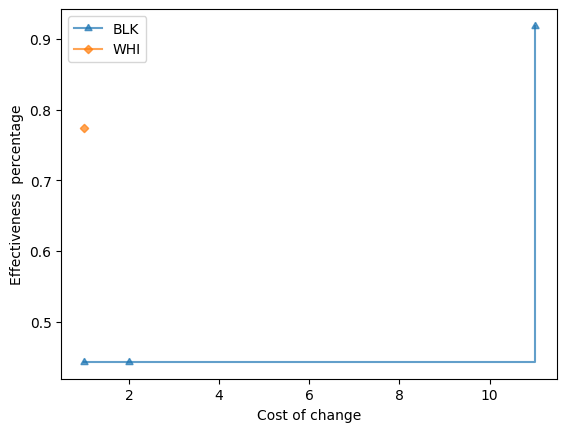

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 1, PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0, SEX CODE CD = F:
	Protected Subgroup 'BLK', 3.94% covered
		Make PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0 with effectiveness 62.15% and counterfactual cost = 1.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30, PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0 with effectiveness 99.65% and counterfactual cost = 11.0.
		Aggregate cost of the above recourses = 11.00
	Protected Subgroup 'WHI', 2.37% covered
		Make PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0 with effectiveness 70.00% and counterfactual cost = 1.0.
		Aggregate cost of the above recourses = 1.00
	Bias against BLK due to Equal Effectiveness. Unfairness score = 10.0.
	Cumulative effectiveness plot for the above recourses:


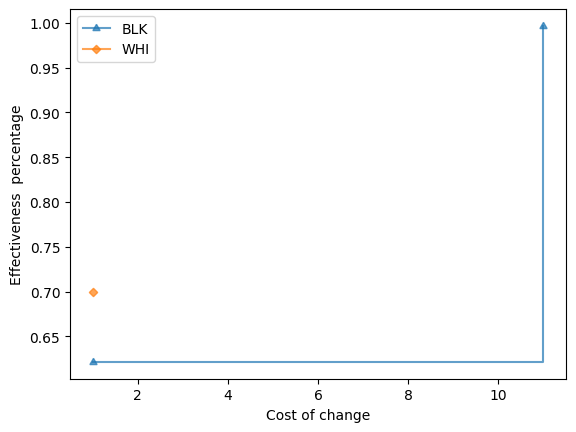

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0, PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 1:
	Protected Subgroup 'BLK', 3.94% covered
		Make PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0 with effectiveness 52.13% and counterfactual cost = 1.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0 with effectiveness 98.23% and counterfactual cost = 11.0.
		Aggregate cost of the above recourses = 11.00
	Protected Subgroup 'WHI', 3.97% covered
		Make PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0 with effectiveness 76.25% and counterfactual cost = 1.0.
		Aggregate cost of the above recourses = 1.00
	Bias against BLK due to Equal Effectiveness. Unfairness score = 10.0.
	Cumulative effectiveness plot for the above recourses:


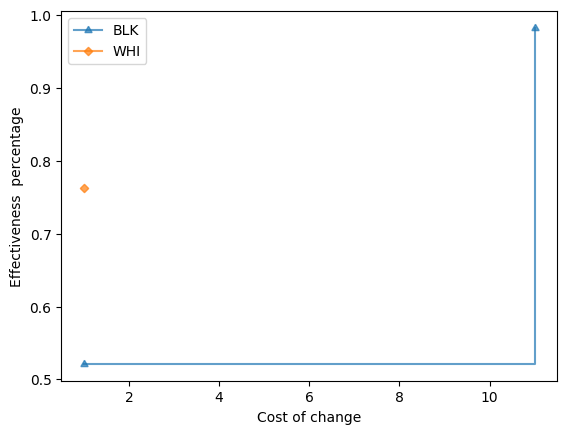

In [12]:
top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
    rules_with_cumulative_correctness,
    metric="min-above-corr",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=top_count,
    cor_threshold = 0.7,
    filter_sequence = [
        "remove-contained",
        "remove-fair-rules",
        "keep-cheap-rules-above-thr-cor",
        
    ],
    params=params
)

print_recourse_report_cumulative(
    top_rules,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    show_cumulative_plots=True,
    correctness_metric=False
)

##  Equal Effectiveness

If PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0:
	Protected Subgroup 'BLK', 1.68% covered
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1, PREDIC

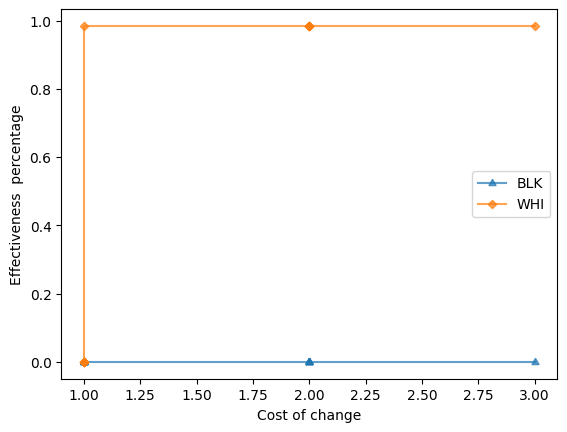

If PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0:
	Protected Subgroup 'BLK', 2.46% covered
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT GANG AFFILIATION = 1 with ef

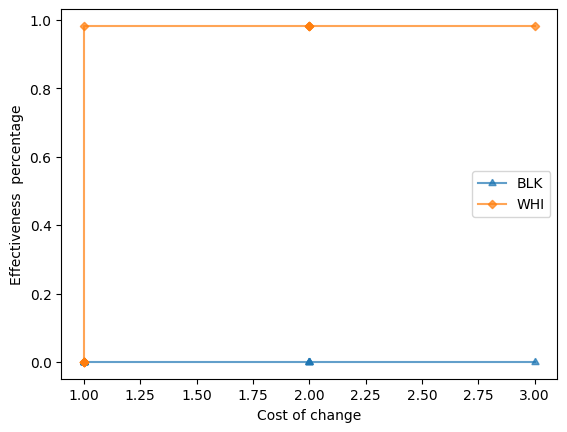

If PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0, SEX CODE CD = M:
	Protected Subgroup 'BLK', 1.13% covered
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC AR

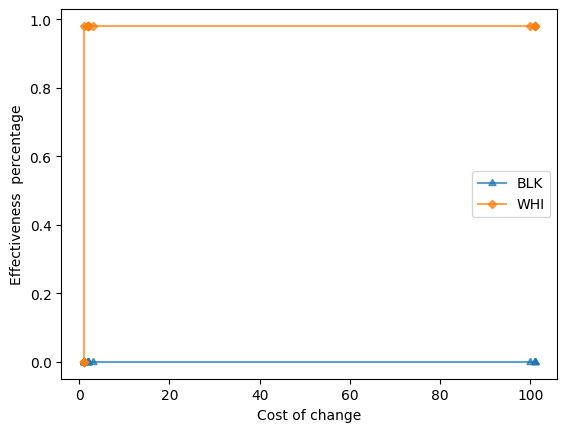

If PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0, SEX CODE CD = M:
	Protected Subgroup 'BLK', 1.73% covered
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT GANG AFFILI

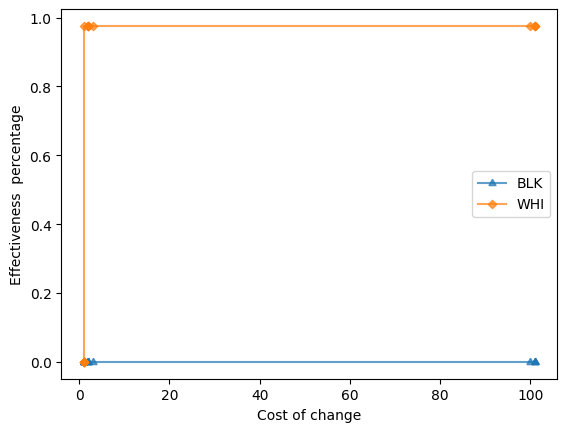

If PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0:
	Protected Subgroup 'BLK', 1.93% covered
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT GANG AFFILIATION = 1 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 3.01% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 4.82% and counterfactual cost = 1.0.
		Make PREDICTOR RAT GANG AFFILIATION = 1, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY =

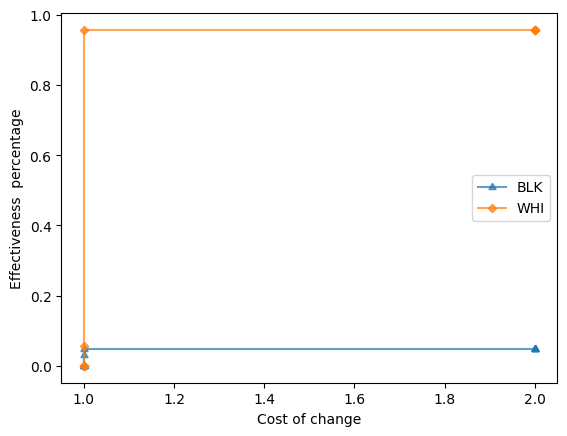

If PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0, PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3]:
	Protected Subgroup 'BLK', 17.98% covered
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 96.35% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 96.35% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 96.35% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 96.35% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1, PREDICTOR RAT TREND IN CRIMINAL A

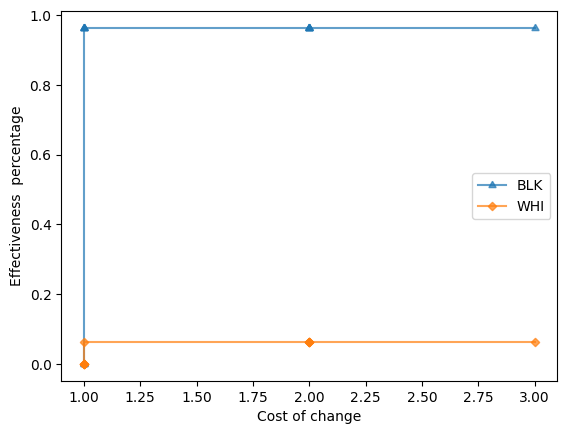

If PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0, SEX CODE CD = M:
	Protected Subgroup 'BLK', 1.44% covered
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1, PREDICTOR RAT TREND IN CR

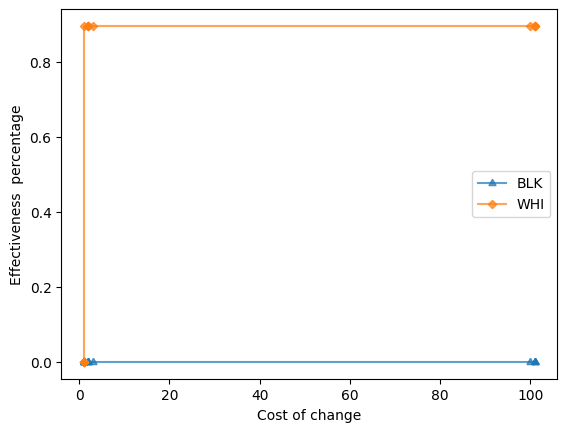

If PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0, SEX CODE CD = M:
	Protected Subgroup 'BLK', 1.37% covered
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT GANG AFFILIATION = 1 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 3.23% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 5.65% and counterfactual cost = 1.0.
		Make PREDICTOR RAT GANG AFFILIATION = 1, PREDICTOR RAT TREND IN CR

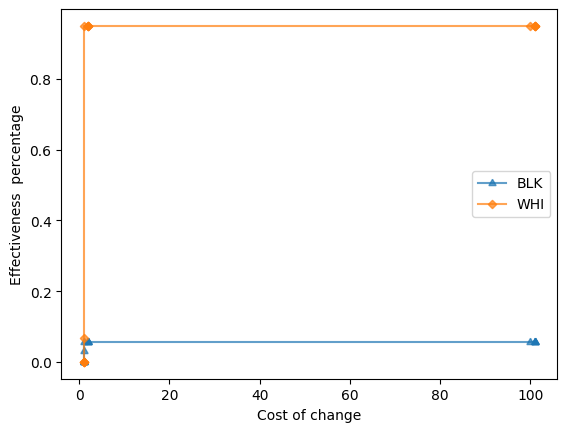

If PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0:
	Protected Subgroup 'BLK', 2.02% covered
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY =

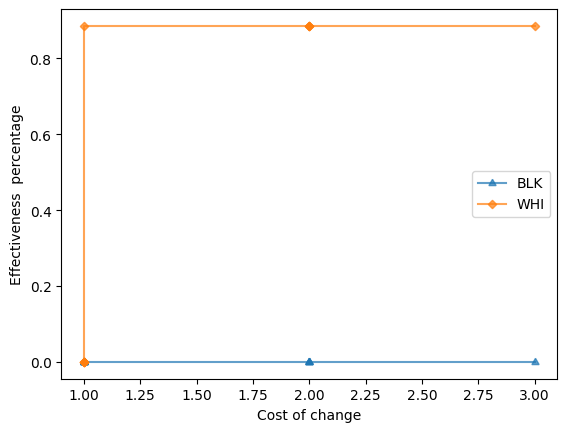

In [13]:
top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
    rules_with_cumulative_correctness,
    metric="total-correctness",
    sort_strategy="generic-sorting-ignore-forall-subgroups-empty",
    top_count=top_count,
    filter_sequence = [
        "remove-contained",
        "remove-fair-rules",
    ],
    params=params
)

print_recourse_report_cumulative(
    top_rules,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    show_cumulative_plots=True,
    correctness_metric=False
)

##  Fair Effectiveness-Cost Trade-Off

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3]:
	Protected Subgroup 'BLK', 6.46% covered out of 8072
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 93.83% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 93.83% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 93.83% and counterfactual cost = 1.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30 with effectiveness 94.02% and counterfactual cost = 10.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 30-40 with effectiveness 99.44% and counterfactual cost = 10.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30, PREDICTO

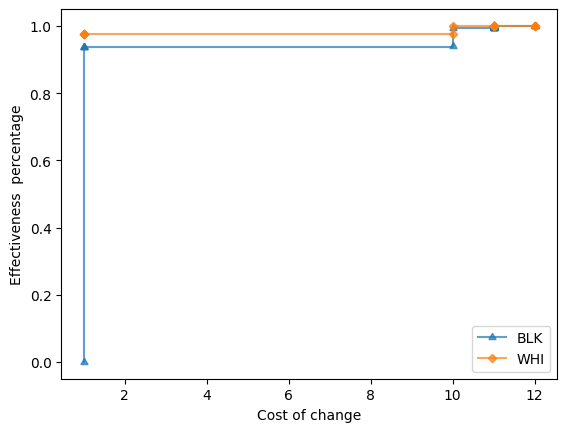

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3], PREDICTOR RAT UUW ARRESTS = 0:
	Protected Subgroup 'BLK', 6.46% covered out of 8072
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 93.83% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 93.83% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 93.83% and counterfactual cost = 1.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30 with effectiveness 94.02% and counterfactual cost = 10.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 30-40 with effectiveness 99.44% and counterfactual cost = 10.0.
		Make PREDICTOR RAT AGE AT 

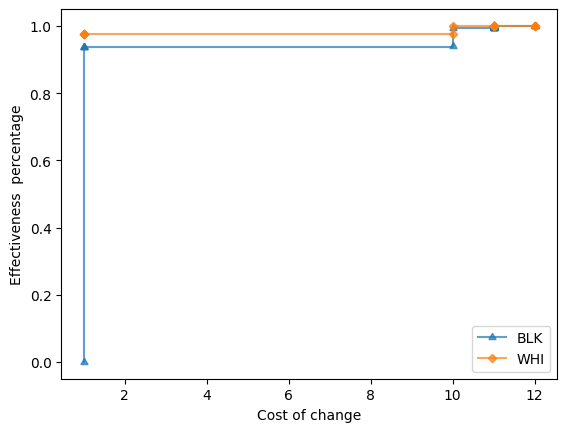

If PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0:
	Protected Subgroup 'BLK', 6.02% covered out of 8072
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 99.80% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 99.80% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 99.80% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 99.80% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARC

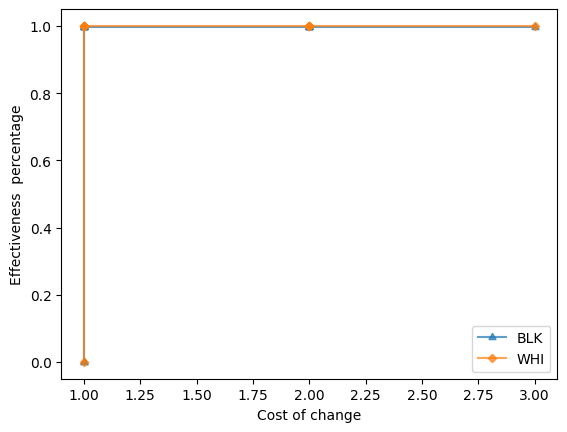

If PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3], PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0:
	Protected Subgroup 'BLK', 6.02% covered out of 8072
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 99.80% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 99.80% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 99.80% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 99.80% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1, PREDICTOR RAT

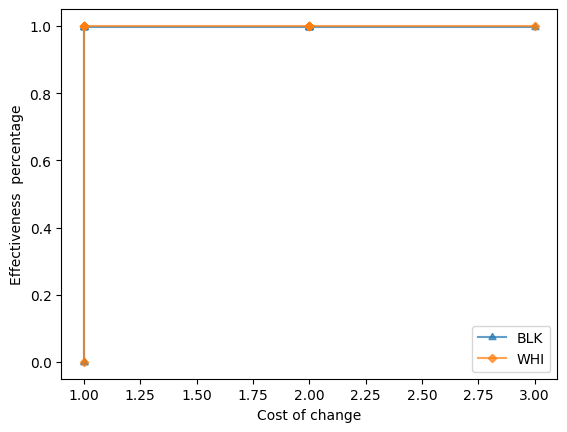

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3], PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0:
	Protected Subgroup 'BLK', 6.02% covered out of 8072
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 99.80% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 99.80% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 99.80% and counterfactual cost = 1.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30 with effectiveness 100.00% and counterfactual cost = 10.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 30-40 with effectiveness 100.00% and counterfactual cost = 10.0.
		Make PREDI

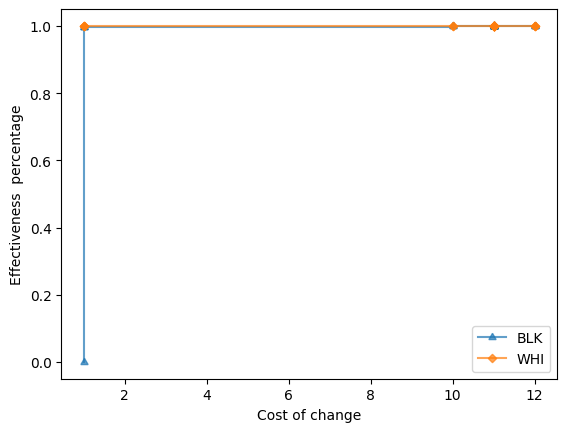

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0:
	Protected Subgroup 'BLK', 6.02% covered out of 8072
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 99.80% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 99.80% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 99.80% and counterfactual cost = 1.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30 with effectiveness 100.00% and counterfactual cost = 10.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 30-40 with effectiveness 100.00% and counterfa

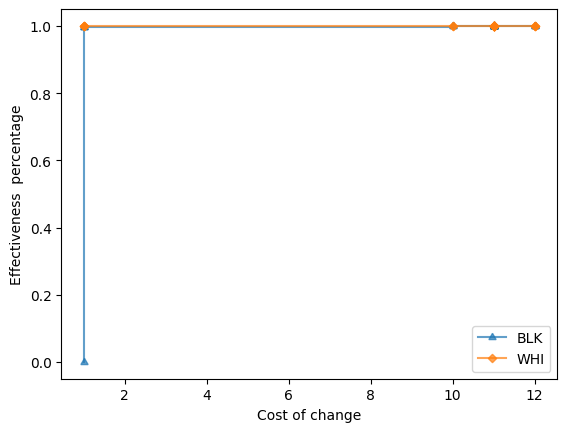

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0:
	Protected Subgroup 'BLK', 6.27% covered out of 8072
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 96.54% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 96.54% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 96.54% and counterfactual cost = 1.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30 with effectiveness 96.54% and counterfactual cost = 10.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 30-40 with effectiveness 99.81% and counterfact

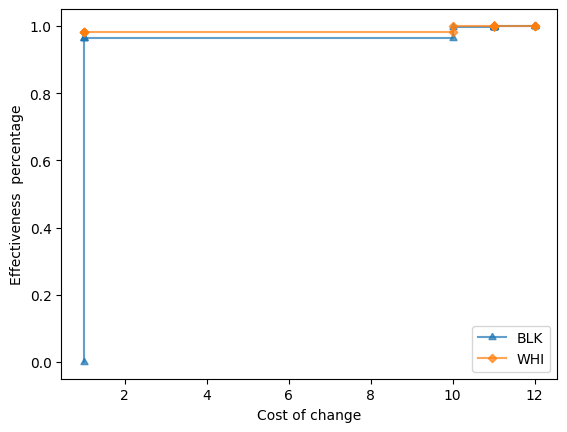

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3], PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0:
	Protected Subgroup 'BLK', 6.27% covered out of 8072
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 96.54% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 96.54% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 96.54% and counterfactual cost = 1.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30 with effectiveness 96.54% and counterfactual cost = 10.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 30-40 with effectiveness 99.81% and counterfactual cost = 10.0.
		Make PREDICT

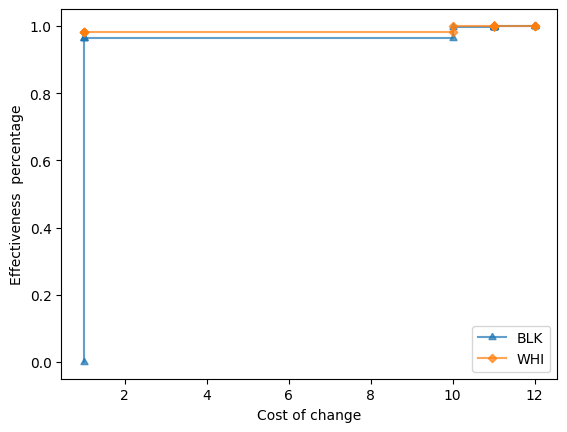

If PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0, PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0:
	Protected Subgroup 'BLK', 6.00% covered out of 8072
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 100.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 100.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 100.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 100.00% and cou

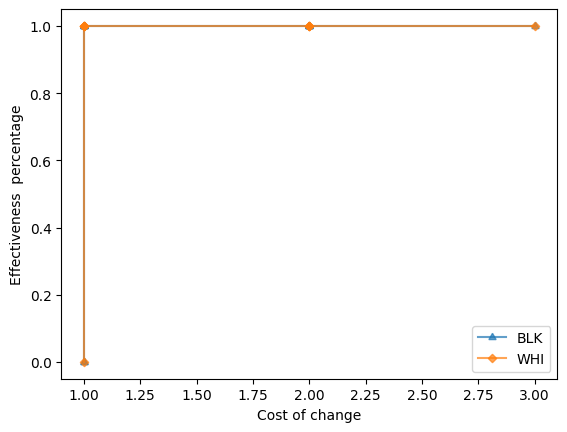

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0, PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0:
	Protected Subgroup 'BLK', 6.00% covered out of 8072
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 100.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 100.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 100.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30 with effectiveness 100.00% and counterfactual cost = 10.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST 

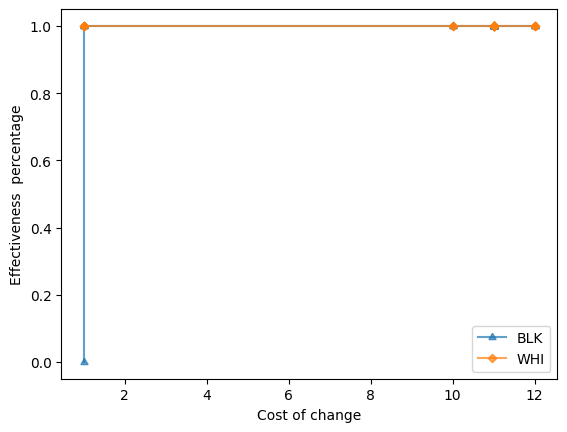

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3], PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0, PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0:
	Protected Subgroup 'BLK', 6.00% covered out of 8072
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 100.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 100.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 100.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30 with effectiveness 100.00% and counterfactual cost = 10.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 30-40 with effectiveness 100.

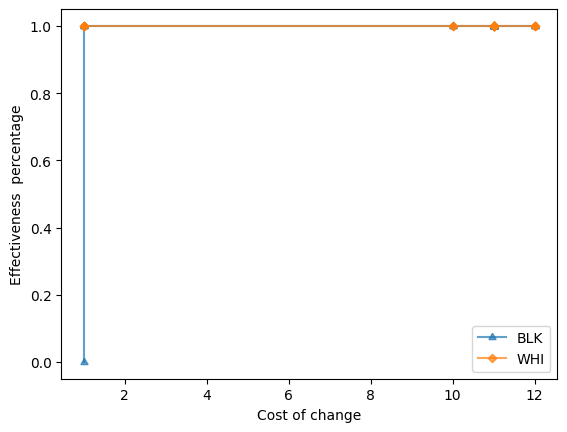

If PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3], PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0, PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0:
	Protected Subgroup 'BLK', 6.00% covered out of 8072
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 100.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 100.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 100.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 100.00% and counterfactual cost = 1.0.
		Make 

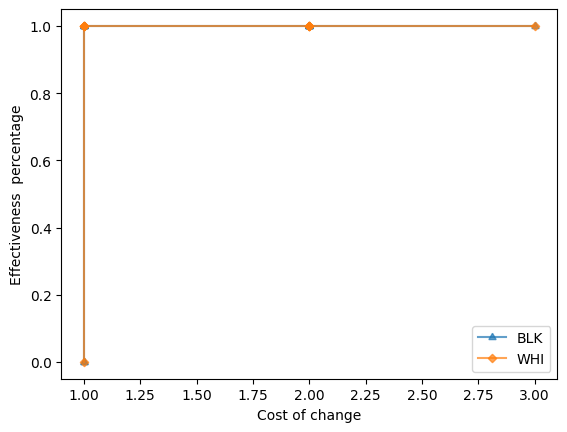

If PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0:
	Protected Subgroup 'BLK', 6.99% covered out of 8072
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 94.47% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 96.43% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 96.43% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 96.43% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARC

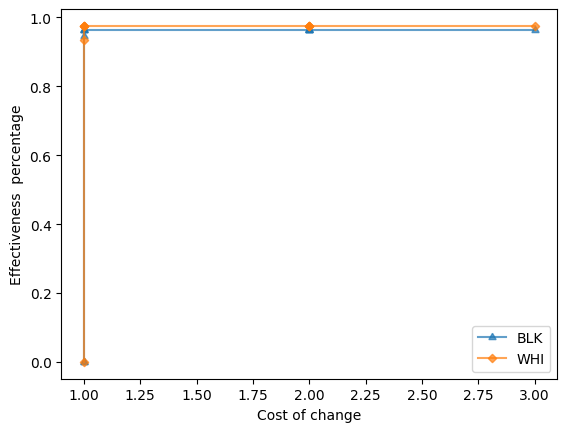

If PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3], PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0:
	Protected Subgroup 'BLK', 6.99% covered out of 8072
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 94.47% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 96.43% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 96.43% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 96.43% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1, PREDICTOR RAT

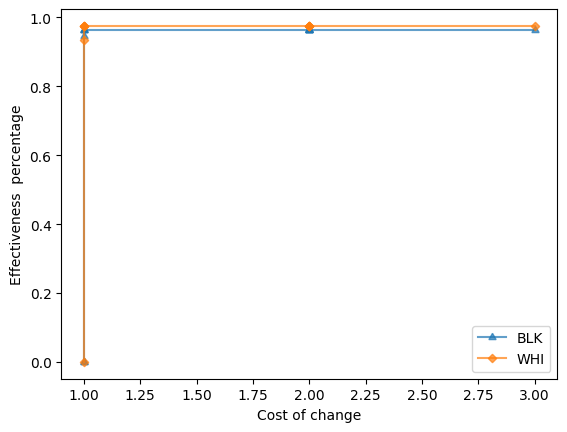

If PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3]:
	Protected Subgroup 'BLK', 7.64% covered out of 8072
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 88.33% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 90.17% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 90.17% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 90.17% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with

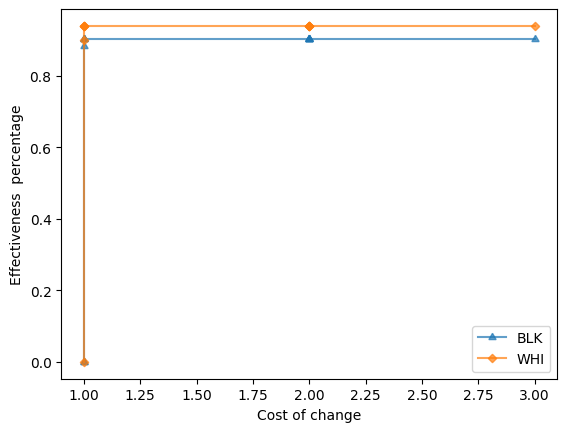

If PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3], PREDICTOR RAT UUW ARRESTS = 0:
	Protected Subgroup 'BLK', 7.64% covered out of 8072
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 88.33% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 90.17% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 90.17% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 90.17% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1, PREDICTOR RAT TREND IN CRIM

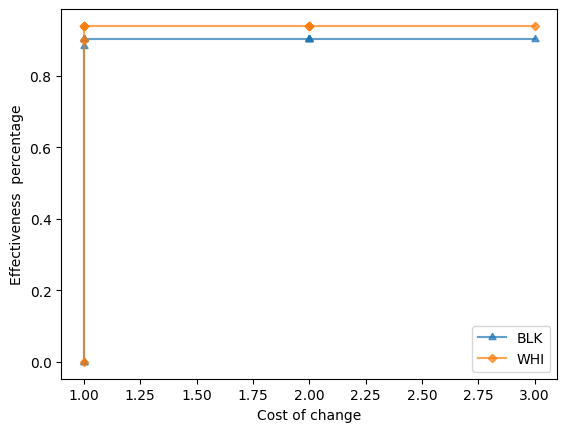

If PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0, PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0:
	Protected Subgroup 'BLK', 5.98% covered out of 8072
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 96.53% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 96.53% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 96.53% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 96.53% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (

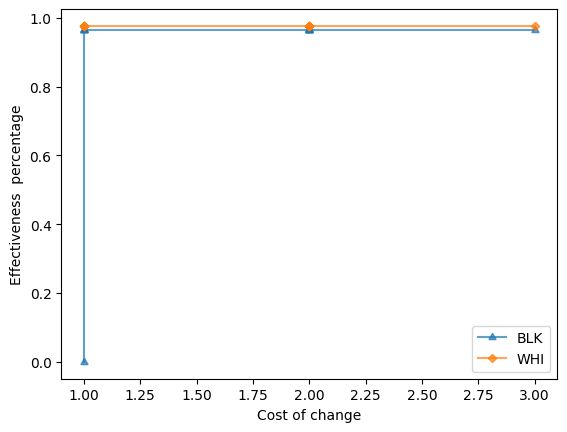

If PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0, PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3], PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0:
	Protected Subgroup 'BLK', 5.98% covered out of 8072
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 96.53% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 96.53% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 96.53% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 96.53% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 9

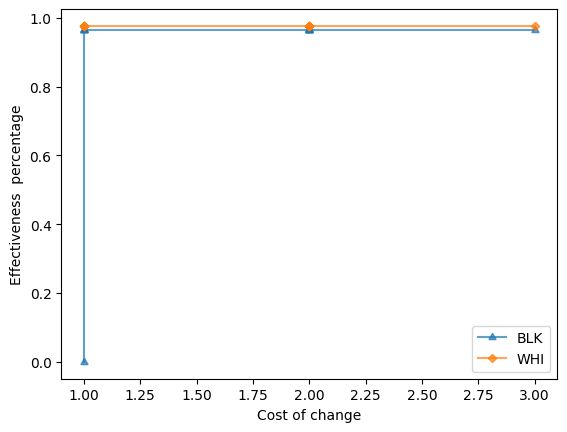

If PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0:
	Protected Subgroup 'BLK', 11.08% covered out of 8072
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.11% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 62.21% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 63.47% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 63.47% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 63.47% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1, PREDICTOR RAT TREND IN CR

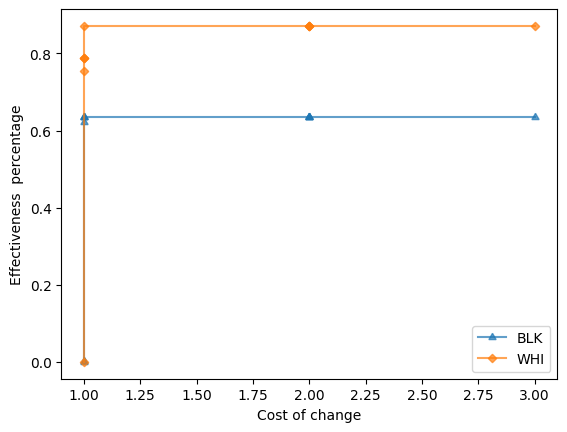

If PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0:
	Protected Subgroup 'BLK', 9.85% covered out of 8072
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.12% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 64.75% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 64.75% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 64.75% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 64.75% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1, PREDICTOR RAT TREND IN CRI

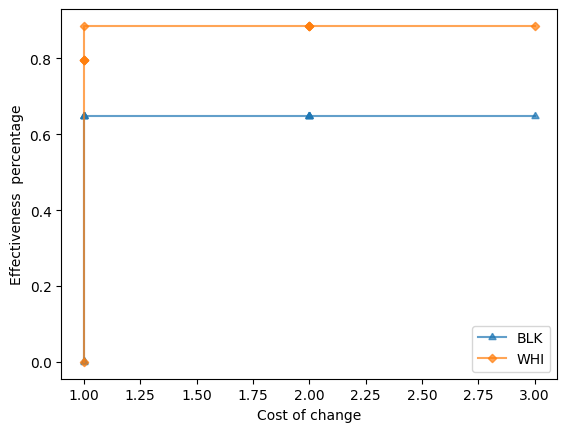

In [15]:
# taken from the other notebooks
affected_pop_sizes = {"BLK": 8072, "WHI": 3271}

top_rules,unfairness = facts.select_rules_subset_KStest(
    rules_with_cumulative_correctness,
    affected_pop_sizes,
    top_count=top_count
)

print_recourse_report_KStest_cumulative(
    top_rules,
    population_sizes=affected_pop_sizes,
    unfairness = unfairness,
    show_then_costs=True,
    show_cumulative_plots=True
)

## Equal Effectiveness within Budget (Micro)

If PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0:
	Protected Subgroup 'BLK', 1.68% covered
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1, PREDIC

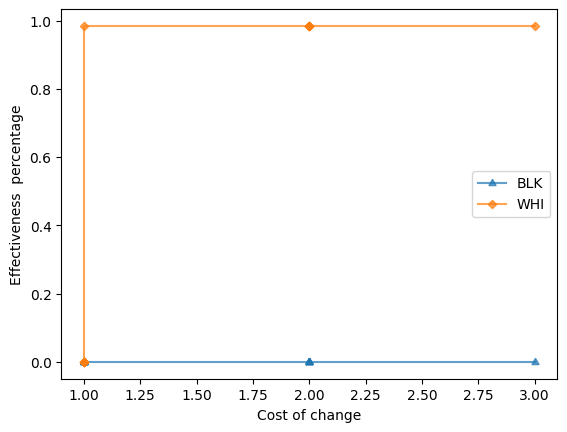

If PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0:
	Protected Subgroup 'BLK', 2.46% covered
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT GANG AFFILIATION = 1 with ef

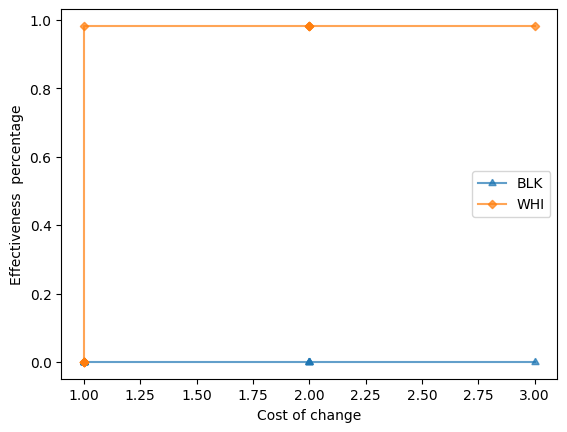

If PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0, SEX CODE CD = M:
	Protected Subgroup 'BLK', 1.13% covered
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC AR

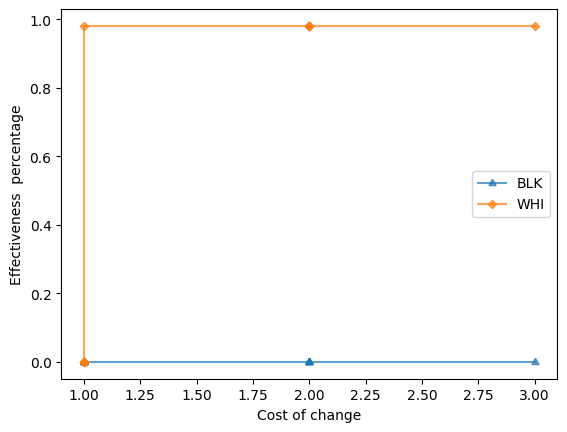

If PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0, SEX CODE CD = M:
	Protected Subgroup 'BLK', 1.73% covered
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT GANG AFFILI

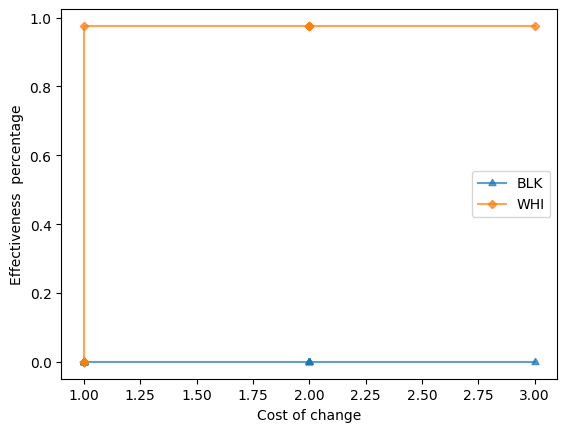

If PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0:
	Protected Subgroup 'BLK', 1.93% covered
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT GANG AFFILIATION = 1 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 3.01% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 4.82% and counterfactual cost = 1.0.
		Make PREDICTOR RAT GANG AFFILIATION = 1, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY =

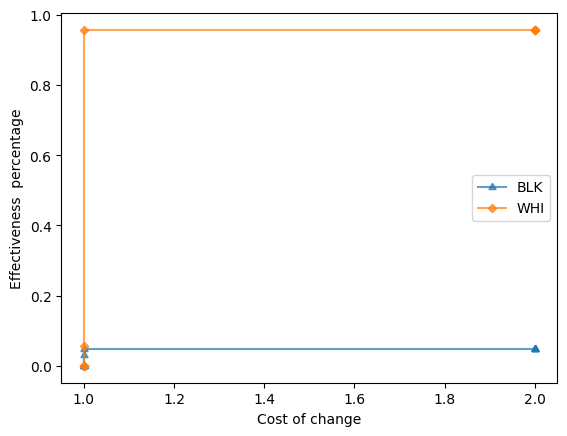

If PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0, PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3]:
	Protected Subgroup 'BLK', 17.98% covered
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 96.35% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 96.35% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 96.35% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 96.35% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1, PREDICTOR RAT TREND IN CRIMINAL A

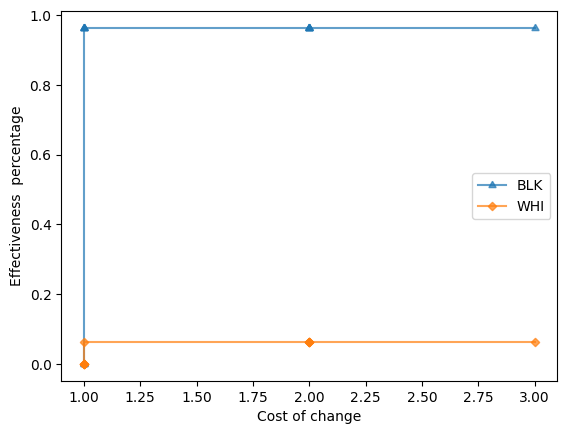

If PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0, SEX CODE CD = M:
	Protected Subgroup 'BLK', 1.44% covered
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1, PREDICTOR RAT TREND IN CR

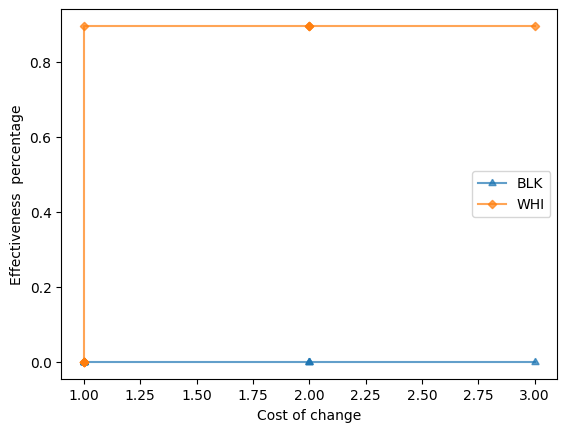

If PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0, SEX CODE CD = M:
	Protected Subgroup 'BLK', 1.37% covered
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT GANG AFFILIATION = 1 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 3.23% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 5.65% and counterfactual cost = 1.0.
		Make PREDICTOR RAT GANG AFFILIATION = 1, PREDICTOR RAT TREND IN CR

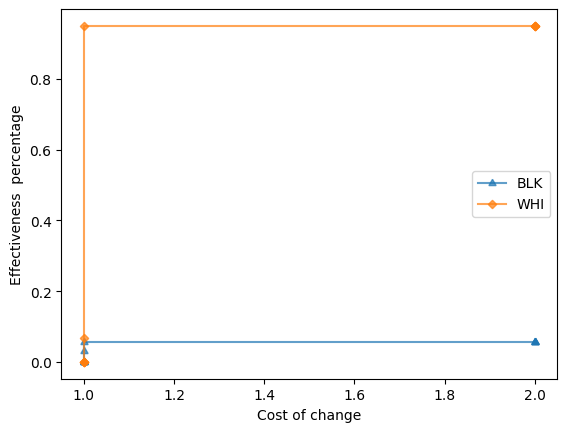

If PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0:
	Protected Subgroup 'BLK', 2.02% covered
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY =

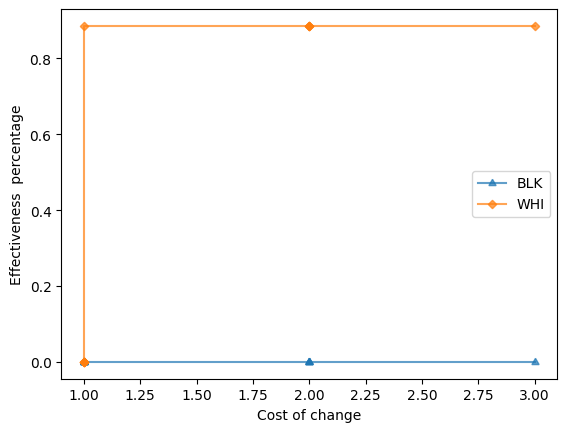

In [16]:
top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
    rules_with_cumulative_correctness,
    metric="max-upto-cost",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=top_count,
    cost_threshold = cost_budget,
    filter_sequence = [
        "remove-contained",
        "remove-fair-rules",
        "remove-above-thr-cost"
    ],
    params=params
)

print_recourse_report_cumulative(
    top_rules,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    show_cumulative_plots=True,
    correctness_metric=False
)

## Get ranking of subgroups based on metrics

In [15]:
rules_with_both = {}
for ifc, all_thens in rules_with_cumulative_correctness.items():
    new_all_thens = {}
    for sg, (cov, thens_cum) in all_thens.items():
        thens_atom = rules_with_atomic_correctness[ifc][sg][1]
        thens_atom_dict = {then: atom_cor for then, atom_cor in thens_atom}
        new_all_thens[sg] = (cov, [(then, thens_atom_dict[then], cumcor) for then, cumcor, _cost in thens_cum])
    rules_with_both[ifc] = new_all_thens

In [16]:
from facts.fairness_metrics_aggr import make_table, auto_budget_calculation
budgets = auto_budget_calculation(rules_with_cumulative_correctness, cor_thres=0.5, percentiles=[0.3, 0.6, 0.9])

df = make_table(
    rules_with_both,
    sensitive_attribute_vals=["BLK", "WHI"],
    effectiveness_thresholds=[0.3, 0.7],
    cost_budgets=budgets,
    params=params
)

df.drop(['weighted-average', 'mean-cost-cinf'], axis=1, inplace=True)
df = df.loc[:, ~df.columns.duplicated()]

In [17]:
from facts.fairness_metrics_aggr import get_diff_table, get_comb_df, get_analysis_dfs

sensitive_attribute_vals=["WHI", "BLK"]
#table of differences between Male and Female for each metric
diff = get_diff_table(df, sensitive_attribute_vals=["BLK", "WHI"], with_abs = True)
diff = diff.set_index('subgroup')
ranked = diff.drop(columns=[('Fair Effectiveness-Cost Trade-Off','bias')]).mask(diff == 0).rank(ascending = False,axis=0,method='dense')
ranked = ranked.replace(np.nan,"Fair")

In [18]:
rev_bias_metrics = ['Equal Effectiveness', 'Equal Effectiveness within Budget']
comb_df = get_comb_df(df, ranked, diff, rev_bias_metrics, sensitive_attribute_vals)
diff_real_val, _, = get_diff_real_diff_drop(df, diff, sensitive_attribute_vals)
analysis_df,rank_analysis_df = get_analysis_dfs(comb_df, diff_real_val, rev_bias_metrics, ranked, sensitive_attribute_vals, percentage=0.1)

In [19]:
comb_df.head()

(Equal Cost of Effectiveness(Macro), 0.3)  \
                                                                                        rank   
subgroup                                                                                       
PREDICTOR RAT UUW ARRESTS = 0                                                           Fair   
SEX CODE CD = M                                                                         Fair   
PREDICTOR RAT AGE AT LATEST ARREST = 10-20                                              Fair   
PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0                                             Fair   
PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0, PR...                                      Fair   

                                                                       \
                                                   score bias against   
subgroup                                                                
PREDICTOR RAT UUW ARRESTS = 0                        0.0         Fair   
SEX CODE CD = M                                      0.0         Fair   
PREDICTOR RAT AGE AT LATEST ARREST = 10-20           0.0         Fair   
PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0          0.0         Fair   
PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0, PR...   0.0         Fair   

                                                   (Equal Cost of Effectiveness(Macro), 0.7)  \
                                                                                        rank   
subgroup                                                                                       
PREDICTOR RAT UUW ARRESTS = 0                                                           Fair   
SEX CODE CD = M                                                                         Fair   
PREDICTOR RAT AGE AT LATEST ARREST = 10-20                                              Fair   
PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0                                             Fair   
PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0, PR...                                      Fair   

                                                                       \
                                                   score bias against   
subgroup                                                                
PREDICTOR RAT UUW ARRESTS = 0                        0.0         Fair   
SEX CODE CD = M                                      0.0         Fair   
PREDICTOR RAT AGE AT LATEST ARREST = 10-20           0.0         Fair   
PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0          0.0         Fair   
PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0, PR...   0.0         Fair   

                                                   (Equal Choice for Recourse, 0.3)  \
                                                                               rank   
subgroup                                                                              
PREDICTOR RAT UUW ARRESTS = 0                                                  Fair   
SEX CODE CD = M                                                                Fair   
PREDICTOR RAT AGE AT LATEST ARREST = 10-20                                     Fair   
PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0                                    Fair   
PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0, PR...                             Fair   

                                                                       \
                                                   score bias against   
subgroup                                                                
PREDICTOR RAT UUW ARRESTS = 0                        0.0         Fair   
SEX CODE CD = M                                      0.0         Fair   
PREDICTOR RAT AGE AT LATEST ARREST = 10-20           0.0         Fair   
PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0          0.0         Fair   
PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0, PR...   0.0         Fair   

                                                   (Equal Cho

In [20]:
analysis_df

,Rank = 1 Count,WHI bias against Count,BLK bias against Count,Top 10% WHI bias against Count,Top 10% BLK bias against Count
"(Equal Cost of Effectiveness(Macro), 0.3)",371,243,934,10,107
"(Equal Cost of Effectiveness(Macro), 0.7)",627,139,1370,26,124
"(Equal Choice for Recourse, 0.3)",1,516,2411,108,184
"(Equal Choice for Recourse, 0.7)",16,399,2678,78,229
Equal Effectiveness,1,775,3273,15,389
"(Equal Effectiveness within Budget, 1.0)",18,937,3606,18,436
"(Equal Effectiveness within Budget, 2.0)",2,885,4626,19,532
"(Equal Effectiveness within Budget, 10.0)",1,835,4796,15,548
"(Equal Cost of Effectiveness(Micro), 0.3)",458,221,1181,5,135
"(Equal Cost of Effectiveness(Micro), 0.7)",671,90,1447,23,130


In [21]:
max_ranks = get_map_metric_to_max_rank(ranked)
rank_divided = get_other_ranks_divided(rank_analysis_df, max_ranks)
rank_divided

,"(Equal Cost of Effectiveness(Macro), 0.3)","(Equal Cost of Effectiveness(Macro), 0.7)","(Equal Choice for Recourse, 0.3)","(Equal Choice for Recourse, 0.7)",Equal Effectiveness,"(Equal Effectiveness within Budget, 1.0)","(Equal Effectiveness within Budget, 2.0)","(Equal Effectiveness within Budget, 10.0)","(Equal Cost of Effectiveness(Micro), 0.3)","(Equal Cost of Effectiveness(Micro), 0.7)",Equal(Conditional) Mean Recourse,"(Fair Effectiveness-Cost Trade-Off, value)"
"(Equal Cost of Effectiveness(Macro), 0.3)",NaN,0.883,0.854,0.988,0.216,0.401,0.285,0.238,0.300,0.843,0.677,0.338
"(Equal Cost of Effectiveness(Macro), 0.7)",0.929,NaN,0.877,0.725,0.239,0.421,0.332,0.264,0.871,0.314,0.829,0.342
"(Equal Choice for Recourse, 0.3)",0.143,1.000,NaN,1.000,0.328,0.704,0.464,0.368,0.143,1.000,0.726,0.601
"(Equal Choice for Recourse, 0.7)",1.000,0.167,0.769,NaN,0.083,0.177,0.127,0.086,1.000,0.143,0.925,0.135
Equal Effectiveness,0.143,0.167,0.923,0.938,NaN,0.002,0.000,0.000,0.143,0.143,0.000,0.003
"(Equal Effectiveness within Budget, 1.0)",0.857,0.833,0.854,0.881,0.890,NaN,0.923,0.876,0.857,0.857,0.326,0.000
"(Equal Effectiveness within Budget, 2.0)",0.286,0.333,0.923,0.938,0.500,0.002,NaN,0.500,0.286,0.286,0.000,0.003
"(Equal Effectiveness within Budget, 10.0)",0.143,0.167,0.923,0.938,0.000,0.002,0.000,NaN,0.143,0.143,0.000,0.003
"(Equal Cost of Effectiveness(Micro), 0.3)",0.443,0.833,0.877,0.969,0.143,0.312,0.198,0.154,NaN,0.843,0.728,0.268
"(Equal Cost of Effectiveness(Micro), 0.7)",0.900,0.383,0.892,0.788,0.203,0.406,0.299,0.225,0.886,NaN,0.816,0.327
